In [1]:
import json
import os
import pickle
import sys
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

with open('../dirs.json', 'r') as f:
    dirs = json.load(f)
sys.path.append(dirs['root'])

from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import StandardScaler

from utils.ipm import NeuronLoader
from utils.metrics import DescriminationConfidenceEstimator as DCE
from utils.utils import mkeqdata
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kendalltau
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.ndimage import gaussian_filter1d as smooth

nmb_rep = 100

outPath = os.path.join(dirs['out']['ff'])
os.makedirs(outPath, exist_ok=True)

In [2]:
monkey = "both"
selectivity = "fast"

# grangerInfluence = {'itc2pfc': {}, 'pfc2itc': {}}
grangerInfluence = {}
with open("../utils/info.pkl", "rb") as handler:
    info = pickle.load(handler)
info = info[:165]
sIndex = ((info.sfr == "A") | (info.sfr == "BI"))
noneIndex = (info.cat == "none")
info = info[~noneIndex & sIndex].reset_index(drop=True)
itc = np.load(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}/ITCNoAvg.npy")
pfc = np.load(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}/PFCNoAvg.npy")
itc = itc[~noneIndex & sIndex]
pfc = pfc[~noneIndex & sIndex]

In [89]:
def movff(inp, bl, ss):
    nbin = int(np.floor((inp.shape[2] - bl) / ss))
    out = np.nan * np.zeros((2, inp.shape[1], nbin))
    for ibin in range(nbin):
        binSC = inp[:, :, int(ibin*ss):int(ibin*ss)+bl].sum((2))
        out[0, :, ibin] = binSC.mean(0)
        out[1, :, ibin] = binSC.var(0)
    return out

In [90]:
bl, ss = 25, 1
itcData = movff(itc, bl, ss)
pfcData = movff(pfc, bl, ss)

In [101]:
from sklearn.linear_model import LinearRegression

ffi, ffp = [], []
for iwin in range(itcData.shape[2]):
    m = itcData[0, :, iwin].reshape([-1, 1])
    s = itcData[1, :, iwin].reshape([-1, 1])

    reg = LinearRegression(fit_intercept=False).fit(m, s)
    # ffi.append([reg.coef_[0][0], reg.intercept_[0]])
    ffi.append(reg.coef_[0][0])
    
    m = pfcData[0, :, iwin].reshape([-1, 1])
    s = pfcData[1, :, iwin].reshape([-1, 1])

    # reg = LinearRegression().fit(m, s)
    reg = LinearRegression(fit_intercept=False).fit(m, s)
    # ffp.append([reg.coef_[0][0], reg.intercept_[0]])
    ffp.append(reg.coef_[0][0])

ffi, ffp = 2.5 * np.array(ffi), 2.5 * np.array(ffp)

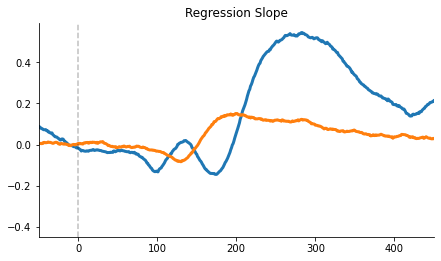

In [105]:
tim = np.arange(-200, 675, step=1) + 25

bln = True

cm = 1 / 2.54 * 2
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9 * cm, 5 * cm))

ax.plot(tim, ffi - (ffi[(tim<0) & (tim>-20)].mean() if bln else 0),
            lw=3)
ax.plot(tim, ffp - (ffp[(tim<0) & (tim>-20)].mean() if bln else 0),
            lw=3)
ax.axvline(0, c='k', alpha=.25, ls='--')
ax.set_title("Regression Slope")

ax.set_xlim(-50, 450)

sns.despine()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

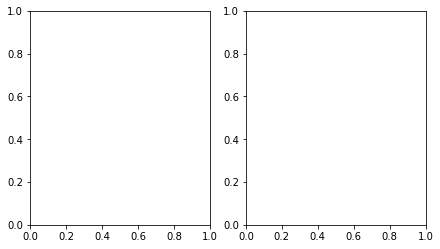

In [97]:
tim = np.arange(-200, 675, step=1) + 25

bln = True

cm = 1 / 2.54 * 2
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9 * cm, 5 * cm))

axs[0].plot(tim, ffi[:, 0] - (ffi[(tim<0) & (tim>-50), 0].mean() if bln else 0),
            lw=3)
axs[0].plot(tim, ffp[:, 0] - (ffp[(tim<0) & (tim>-50), 0].mean() if bln else 0),
            lw=3)
axs[0].axvline(0, c='k', alpha=.25, ls='--')
axs[0].set_title("Regression Slope")

axs[1].plot(tim, ffi[:, 1] - (ffi[(tim<0) & (tim>-50), 1].mean() if bln else 0),
            lw=3)
axs[1].plot(tim, ffp[:, 1] - (ffp[(tim<0) & (tim>-50), 1].mean() if bln else 0),
            lw=3)
axs[1].axvline(0, c='k', alpha=.25, ls='--')
axs[1].set_title("Regression Intercept")

axs[0].legend(["ITC", "PFC"], frameon=False)

for ax in axs:
    ax.set_xlim(-50, 450)

sns.despine()